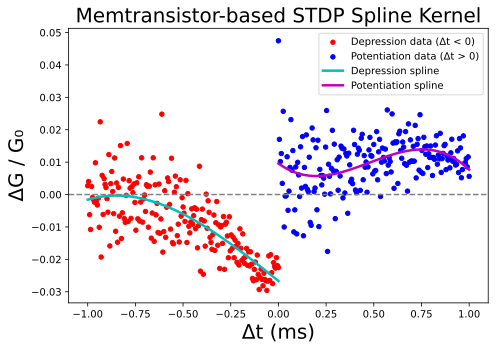

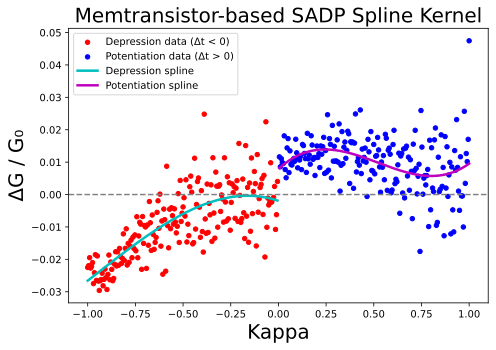

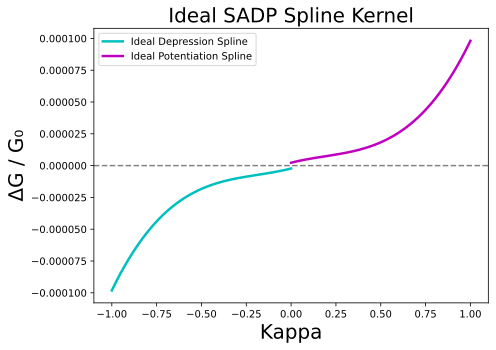

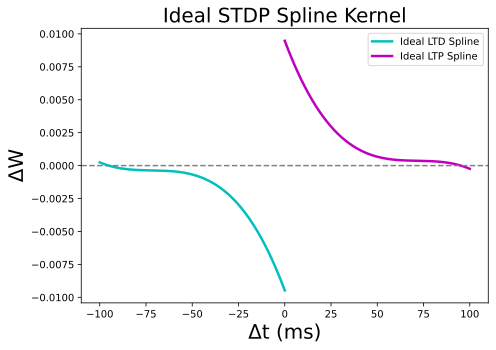

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score
%run SADP_functions.ipynb

In [2]:
# ---------------- HELPERS ----------------
def extract_spike_count_features(model, x_spike, batch_size=128, timesteps=10):
    """
    Run the SNN model on spike-encoded inputs and return spike-count features.
    Assumes the SNN model returns output with shape (N, neurons, timesteps) or (N, timesteps, neurons).
    Returns:
      features: np.array shape (N, neurons) = spike counts per neuron across timesteps
      raw: raw output array shape (N, neurons, timesteps)
    """
    out = model.predict(x_spike, batch_size=batch_size, verbose=0)
    if tf.is_tensor(out):
        out = out.numpy()
    if out.ndim != 3:
        raise ValueError(f"Expected 3D output from SNN (N,neurons,timesteps) or (N,timesteps,neurons). Got shape {out.shape}")
    # If shape is (N, timesteps, neurons), swap
    if out.shape[1] == timesteps and out.shape[2] != timesteps:
        out = np.transpose(out, (0, 2, 1))  # -> (N, neurons, timesteps)
    # Sum over timesteps to get spike-count per neuron
    spike_counts = out.sum(axis=-1)  # (N, neurons)
    return spike_counts, out

def safe_unpack_sadp_return(sadp_ret, total_wall_time, epochs):
    """
    Accept flexible SADP return types.
    Preferred SADP return: (w_norms_list, per_epoch_times_list)
    If only w_norms_list is returned, compute avg epoch time = total_wall_time / epochs.
    Returns (w_norms_list, per_epoch_times_list)
    """
    # Default fallback
    avg_epoch = total_wall_time / epochs if epochs > 0 else total_wall_time
    if sadp_ret is None:
        return [], [avg_epoch] * epochs

    # If it's a tuple/list with two elements and second is list-like -> interpret directly
    if isinstance(sadp_ret, (tuple, list)) and len(sadp_ret) == 2:
        w_norms, per_epoch_times = sadp_ret
        # If the second is a scalar (unexpected), fallback
        if np.isscalar(per_epoch_times):
            per_epoch_times = [float(per_epoch_times)] * epochs
        return list(w_norms), list(per_epoch_times)

    # If it's list/array -> treat as w_norms only
    if isinstance(sadp_ret, (list, np.ndarray)):
        return list(sadp_ret), [avg_epoch] * epochs

    # Otherwise unknown -> fallback empty
    return [], [avg_epoch] * epochs

# ---------------- BENCHMARK RUNNER ----------------
def run_full_benchmark(encoding_name, model_type, sadp_method):
    print(f"\n=== Testing {encoding_name} | {model_type} | {sadp_method.__name__} ===")

    # 1) Spike encoding function
    encode_fn = rate_coding if encoding_name == 'rate' else ttfs_coding
    x_train_spike = encode_fn(x_train, timesteps)  # expected shape depends on your SNN input
    x_test_spike  = encode_fn(x_test, timesteps)

    # Convert to tf tensors only if your model expects them (many do)
    x_train_spike_tf = tf.convert_to_tensor(x_train_spike)
    x_test_spike_tf  = tf.convert_to_tensor(x_test_spike)

    # 2) Build SNN
    if model_type == '1layer_small':
        model = build_snn_1layer_small(num_timesteps=timesteps)
    elif model_type == '1layer':
        model = build_snn_1layer(num_timesteps=timesteps)
    else:
        raise ValueError("Unknown model_type: " + str(model_type))

    # Force build by running a single sample if necessary
    try:
        _ = model(x_train_spike_tf[:1])
    except Exception:
        # Some SNN models might not take TF tensors; try numpy
        try:
            _ = model(x_train_spike[:1])
        except Exception:
            pass

    # 3) Prepare SADP args
    sadp_args = {
        'model': model,
        'x_train': x_train_spike_tf,
        'y_train': (rate_code_labels(y_train_cat, timesteps) if encoding_name == 'rate'
                    else ttfs_code_labels(y_train_cat, timesteps)),
        'epochs': sadp_epochs,
        'batch_size': batch_size,
        'learning_rate': sadp_lr,
        'V_thresh': V_thresh
    }
    if sadp_method.__name__ == 'train_on_chip_spline':
        sadp_args.update({'spline_pot': spline_pot, 'spline_dep': spline_dep})
    elif sadp_method.__name__ == 'train_on_chip_spline_ideal':
        sadp_args.update({'spline_pot_ideal': spline_pot_ideal, 'spline_dep_ideal': spline_dep_ideal})

    # 4) Run SADP and time
    t0 = time.time()
    sadp_ret = sadp_method(**sadp_args)  # user-provided function; prefer returning (w_norms, per_epoch_times)
    total_sadp_time = time.time() - t0

    # Unpack SADP return safely
    w_norms, per_epoch_times = safe_unpack_sadp_return(sadp_ret, total_sadp_time, sadp_epochs)
    # ensure lengths
    if len(per_epoch_times) != sadp_epochs:
        per_epoch_times = ([float(total_sadp_time) / sadp_epochs] * sadp_epochs)

    # 5) Extract features: spike-count per neuron
    # we call model.predict on all data and sum across timesteps
    # if model expects TF tensors, pass those; otherwise pass numpy arrays
    try:
        train_feats, train_raw = extract_spike_count_features(model, x_train_spike_tf, batch_size=batch_size, timesteps=timesteps)
        test_feats, test_raw = extract_spike_count_features(model, x_test_spike_tf, batch_size=batch_size, timesteps=timesteps)
    except Exception:
        # fallback to numpy arrays
        train_feats, train_raw = extract_spike_count_features(model, x_train_spike, batch_size=batch_size, timesteps=timesteps)
        test_feats, test_raw = extract_spike_count_features(model, x_test_spike, batch_size=batch_size, timesteps=timesteps)

    # Validate feature dims
    #assert train_feats.ndim == 2 and train_feats.shape[1] == n_hidden, \
    #    f"Expected features shape (N, {n_hidden}). Got {train_feats.shape}"

    # 6) Downstream classifier (simple dense)
    classifier = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(train_feats.shape[1],)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    hist = classifier.fit(train_feats, y_train_cat, validation_data=(test_feats, y_test_cat),
                          epochs=classifier_epochs, batch_size=batch_size, verbose=1)

    # Evaluate and metrics
    y_pred_prob = classifier.predict(test_feats, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    test_acc = accuracy_score(y_test, y_pred)
    test_f1  = f1_score(y_test, y_pred, average='macro')

    return {
        'sadp_time_total': total_sadp_time,
        'per_epoch_times': per_epoch_times,
        'test_accuracy': float(test_acc),
        'test_f1': float(test_f1),
        'W_norms': list(w_norms),
        'History': hist.history,
        'model': model
    }

In [3]:
# CONFIG
tf.config.optimizer.set_jit(True)
dataset_name = "fmnist"   # or "mnist"
timesteps = 10
sadp_epochs = 10
classifier_epochs = 50
batch_size = 64
sadp_lr = 0.1
V_thresh = 0.5

# DATA
if dataset_name == "mnist":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
else:
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# TEST CASES
test_cases = [
    # (encoding_name, model_type, sadp_method)
    ('rate', '1layer_small', train_on_chip_linear),
    ('rate', '1layer_small', train_on_chip_spline),
    ('rate', '1layer_small', train_on_chip_spline_ideal),
    ('ttfs', '1layer_small', train_on_chip_linear),
    ('ttfs', '1layer_small', train_on_chip_spline),
    ('ttfs', '1layer_small', train_on_chip_spline_ideal),
    ('rate', '1layer', train_on_chip_linear),
    ('rate', '1layer', train_on_chip_spline),
    ('rate', '1layer', train_on_chip_spline_ideal),
    ('ttfs', '1layer', train_on_chip_linear),
    ('ttfs', '1layer', train_on_chip_spline),
    ('ttfs', '1layer', train_on_chip_spline_ideal),
]


In [4]:
# MAIN
all_results = []
for encoding, model_type, method in test_cases:
    try:
        res = run_full_benchmark(encoding, model_type, method)
    except Exception as e:
        print(f"ERROR running {encoding}-{model_type}-{method.__name__}: {e}")
        continue

    all_results.append({
        'Model': method.__name__.replace('train_on_chip_', '') + ' SADP',
        'Coding': encoding,
        'Classifier': model_type,
        'Accuracy': res['test_accuracy'],
        'F1': res['test_f1'],
        'Runtime_sec': res['sadp_time_total'],
        'Per_epoch_sec': res['per_epoch_times'],
        'W_norms': res['W_norms'],
        'History': res['History']
    })
    # clear TF session to avoid memory buildup between runs (rebuild next loop)
    tf.keras.backend.clear_session()




=== Testing rate | 1layer_small | train_on_chip_linear ===

Epoch 1/10


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:32<00:00, 28.76it/s]


  Avg Output Spikes: 0.6801
  Final Layer Weight Norm: 153.0886

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:28<00:00, 32.33it/s]


  Avg Output Spikes: 0.6713
  Final Layer Weight Norm: 165.0704

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:37<00:00, 24.97it/s]


  Avg Output Spikes: 0.6605
  Final Layer Weight Norm: 172.8809

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:25<00:00, 37.06it/s]


  Avg Output Spikes: 0.6683
  Final Layer Weight Norm: 178.5217

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 40.89it/s]


  Avg Output Spikes: 0.6807
  Final Layer Weight Norm: 182.7944

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:27<00:00, 34.19it/s]


  Avg Output Spikes: 0.6727
  Final Layer Weight Norm: 186.1622

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:27<00:00, 33.91it/s]


  Avg Output Spikes: 0.6720
  Final Layer Weight Norm: 188.9013

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:32<00:00, 28.89it/s]


  Avg Output Spikes: 0.6877
  Final Layer Weight Norm: 191.1426

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:29<00:00, 31.29it/s]


  Avg Output Spikes: 0.6671
  Final Layer Weight Norm: 192.9738

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:26<00:00, 35.21it/s]


  Avg Output Spikes: 0.6856
  Final Layer Weight Norm: 194.5056
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 4.1098 - accuracy: 0.0980 - val_loss: 2.4234 - val_accuracy: 0.1986
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 1.9995 - accuracy: 0.3166 - val_loss: 1.7028 - val_accuracy: 0.4098
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 1.5422 - accuracy: 0.4663 - val_loss: 1.4272 - val_accuracy: 0.4984
Epoch 4/50
938/938 [==============================] - 1s 2ms/step - loss: 1.3409 - accuracy: 0.5324 - val_loss: 1.2876 - val_accuracy: 0.5430
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 1.2275 - accuracy: 0.5676 - val_loss: 1.2022 - val_accuracy: 0.5708
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.1541 - accuracy: 0.5912 - val_loss: 1.1449 - val_accuracy: 0.5868
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 1.1027 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:36<00:00, 25.75it/s]


  Avg Output Spikes: 0.7724
  Final Layer Weight Norm: 131.1059

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:37<00:00, 25.24it/s]


  Avg Output Spikes: 0.7292
  Final Layer Weight Norm: 135.8018

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:33<00:00, 28.27it/s]


  Avg Output Spikes: 0.6922
  Final Layer Weight Norm: 142.9038

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:33<00:00, 28.24it/s]


  Avg Output Spikes: 0.6162
  Final Layer Weight Norm: 150.1789

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:32<00:00, 28.55it/s]


  Avg Output Spikes: 0.5332
  Final Layer Weight Norm: 155.7697

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:32<00:00, 28.71it/s]


  Avg Output Spikes: 0.4872
  Final Layer Weight Norm: 158.0900

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:39<00:00, 23.46it/s]


  Avg Output Spikes: 0.5089
  Final Layer Weight Norm: 158.2166

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:33<00:00, 27.87it/s]


  Avg Output Spikes: 0.4888
  Final Layer Weight Norm: 158.2166

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:27<00:00, 33.66it/s]


  Avg Output Spikes: 0.4906
  Final Layer Weight Norm: 158.2166

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:29<00:00, 31.26it/s]


  Avg Output Spikes: 0.4826
  Final Layer Weight Norm: 158.2166
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 3.5810 - accuracy: 0.1675 - val_loss: 2.7465 - val_accuracy: 0.2221
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 2.4028 - accuracy: 0.2830 - val_loss: 2.1443 - val_accuracy: 0.3240
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.9479 - accuracy: 0.3724 - val_loss: 1.8173 - val_accuracy: 0.3897
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.6923 - accuracy: 0.4324 - val_loss: 1.6232 - val_accuracy: 0.4377
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.5371 - accuracy: 0.4684 - val_loss: 1.4998 - val_accuracy: 0.4693
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.4362 - accuracy: 0.4951 - val_loss: 1.4180 - val_accuracy: 0.4940
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.3674 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:23<00:00, 39.45it/s]


  Avg Output Spikes: 0.7206
  Final Layer Weight Norm: 129.8906

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:25<00:00, 36.66it/s]


  Avg Output Spikes: 0.7383
  Final Layer Weight Norm: 129.8920

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:25<00:00, 37.02it/s]


  Avg Output Spikes: 0.7333
  Final Layer Weight Norm: 129.8934

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:21<00:00, 42.69it/s]


  Avg Output Spikes: 0.7238
  Final Layer Weight Norm: 129.8948

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.41it/s]


  Avg Output Spikes: 0.7259
  Final Layer Weight Norm: 129.8962

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.74it/s]


  Avg Output Spikes: 0.7332
  Final Layer Weight Norm: 129.8976

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.70it/s]


  Avg Output Spikes: 0.7396
  Final Layer Weight Norm: 129.8990

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:21<00:00, 42.98it/s]


  Avg Output Spikes: 0.7360
  Final Layer Weight Norm: 129.9005

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.22it/s]


  Avg Output Spikes: 0.7132
  Final Layer Weight Norm: 129.9019

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.54it/s]


  Avg Output Spikes: 0.7405
  Final Layer Weight Norm: 129.9033
Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 3.3934 - accuracy: 0.1276 - val_loss: 2.2734 - val_accuracy: 0.2175
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 1.9264 - accuracy: 0.3152 - val_loss: 1.7070 - val_accuracy: 0.3837
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.5315 - accuracy: 0.4478 - val_loss: 1.4347 - val_accuracy: 0.4875
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.3268 - accuracy: 0.5268 - val_loss: 1.2852 - val_accuracy: 0.5467
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2112 - accuracy: 0.5686 - val_loss: 1.1970 - val_accuracy: 0.5726
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.1381 - accuracy: 0.5928 - val_loss: 1.1368 - val_accuracy: 0.5969
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.0882 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 46.85it/s]


  Avg Output Spikes: 0.2092
  Final Layer Weight Norm: 194.7079

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 48.73it/s]


  Avg Output Spikes: 0.2067
  Final Layer Weight Norm: 195.9453

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 48.94it/s]


  Avg Output Spikes: 0.2065
  Final Layer Weight Norm: 196.2008

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 47.65it/s]


  Avg Output Spikes: 0.2073
  Final Layer Weight Norm: 196.2656

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 48.22it/s]


  Avg Output Spikes: 0.2060
  Final Layer Weight Norm: 196.2861

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 48.89it/s]


  Avg Output Spikes: 0.2063
  Final Layer Weight Norm: 196.2991

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 49.13it/s]


  Avg Output Spikes: 0.2059
  Final Layer Weight Norm: 196.3106

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 49.17it/s]


  Avg Output Spikes: 0.2071
  Final Layer Weight Norm: 196.3184

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 49.20it/s]


  Avg Output Spikes: 0.2053
  Final Layer Weight Norm: 196.3251

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 48.87it/s]


  Avg Output Spikes: 0.2077
  Final Layer Weight Norm: 196.3299
Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 2.7236 - accuracy: 0.1211 - val_loss: 2.2117 - val_accuracy: 0.2143
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 2.1362 - accuracy: 0.2426 - val_loss: 2.0725 - val_accuracy: 0.2448
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 2.0267 - accuracy: 0.2728 - val_loss: 1.9880 - val_accuracy: 0.2896
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.9596 - accuracy: 0.2926 - val_loss: 1.9398 - val_accuracy: 0.2939
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.9195 - accuracy: 0.3056 - val_loss: 1.9085 - val_accuracy: 0.3093
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.8926 - accuracy: 0.3113 - val_loss: 1.8865 - val_accuracy: 0.3073
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.8738 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:23<00:00, 40.20it/s]


  Avg Output Spikes: 0.6863
  Final Layer Weight Norm: 142.6397

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:23<00:00, 40.71it/s]


  Avg Output Spikes: 0.7200
  Final Layer Weight Norm: 150.5655

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:24<00:00, 38.12it/s]


  Avg Output Spikes: 0.7171
  Final Layer Weight Norm: 153.7491

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.09it/s]


  Avg Output Spikes: 0.7312
  Final Layer Weight Norm: 155.5777

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.15it/s]


  Avg Output Spikes: 0.7302
  Final Layer Weight Norm: 156.6039

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.40it/s]


  Avg Output Spikes: 0.7369
  Final Layer Weight Norm: 157.1691

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.06it/s]


  Avg Output Spikes: 0.7342
  Final Layer Weight Norm: 157.4486

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:24<00:00, 38.84it/s]


  Avg Output Spikes: 0.7324
  Final Layer Weight Norm: 157.6810

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:23<00:00, 40.29it/s]


  Avg Output Spikes: 0.7393
  Final Layer Weight Norm: 157.8795

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.55it/s]


  Avg Output Spikes: 0.7316
  Final Layer Weight Norm: 158.0472
Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 3.0033 - accuracy: 0.1400 - val_loss: 2.2567 - val_accuracy: 0.1457
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 2.2241 - accuracy: 0.1601 - val_loss: 2.1950 - val_accuracy: 0.1949
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 2.1745 - accuracy: 0.1935 - val_loss: 2.1577 - val_accuracy: 0.2125
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 2.1422 - accuracy: 0.2181 - val_loss: 2.1287 - val_accuracy: 0.1999
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 2.1156 - accuracy: 0.2352 - val_loss: 2.1020 - val_accuracy: 0.2523
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 2.0922 - accuracy: 0.2513 - val_loss: 2.0809 - val_accuracy: 0.2535
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 2.0738 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:23<00:00, 39.98it/s]


  Avg Output Spikes: 0.6108
  Final Layer Weight Norm: 129.0810

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:23<00:00, 40.47it/s]


  Avg Output Spikes: 0.6110
  Final Layer Weight Norm: 129.0926

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:23<00:00, 40.45it/s]


  Avg Output Spikes: 0.6070
  Final Layer Weight Norm: 129.1043

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:24<00:00, 38.00it/s]


  Avg Output Spikes: 0.5959
  Final Layer Weight Norm: 129.1160

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:24<00:00, 38.57it/s]


  Avg Output Spikes: 0.6000
  Final Layer Weight Norm: 129.1278

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:31<00:00, 29.66it/s]


  Avg Output Spikes: 0.5949
  Final Layer Weight Norm: 129.1397

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:31<00:00, 29.37it/s]


  Avg Output Spikes: 0.6049
  Final Layer Weight Norm: 129.1517

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:32<00:00, 28.69it/s]


  Avg Output Spikes: 0.5977
  Final Layer Weight Norm: 129.1636

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:34<00:00, 27.18it/s]


  Avg Output Spikes: 0.5780
  Final Layer Weight Norm: 129.1757

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:24<00:00, 37.78it/s]


  Avg Output Spikes: 0.5973
  Final Layer Weight Norm: 129.1878
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 2.8467 - accuracy: 0.1482 - val_loss: 2.1756 - val_accuracy: 0.2430
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 1.9173 - accuracy: 0.3325 - val_loss: 1.7153 - val_accuracy: 0.3922
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.5695 - accuracy: 0.4433 - val_loss: 1.4644 - val_accuracy: 0.4716
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.3780 - accuracy: 0.5087 - val_loss: 1.3198 - val_accuracy: 0.5229
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2604 - accuracy: 0.5504 - val_loss: 1.2241 - val_accuracy: 0.5633
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.1798 - accuracy: 0.5780 - val_loss: 1.1559 - val_accuracy: 0.5865
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.1211 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:23<00:00, 11.27it/s]


  Avg Output Spikes: 0.7246
  Final Layer Weight Norm: 376.4777

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:21<00:00, 11.56it/s]


  Avg Output Spikes: 0.7251
  Final Layer Weight Norm: 406.5764

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:24<00:00, 11.06it/s]


  Avg Output Spikes: 0.7237
  Final Layer Weight Norm: 427.0276

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:24<00:00, 11.09it/s]


  Avg Output Spikes: 0.7319
  Final Layer Weight Norm: 441.9001

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:20<00:00, 11.65it/s]


  Avg Output Spikes: 0.7372
  Final Layer Weight Norm: 453.1802

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:20<00:00, 11.57it/s]


  Avg Output Spikes: 0.7393
  Final Layer Weight Norm: 461.9511

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:21<00:00, 11.55it/s]


  Avg Output Spikes: 0.7388
  Final Layer Weight Norm: 468.9583

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:22<00:00, 11.37it/s]


  Avg Output Spikes: 0.7328
  Final Layer Weight Norm: 474.6761

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:16<00:00, 12.18it/s]


  Avg Output Spikes: 0.7451
  Final Layer Weight Norm: 479.3752

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [01:19<00:00, 11.78it/s]


  Avg Output Spikes: 0.7387
  Final Layer Weight Norm: 483.3185
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 2.6519 - accuracy: 0.3098 - val_loss: 1.5461 - val_accuracy: 0.4977
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 1.3235 - accuracy: 0.5602 - val_loss: 1.1922 - val_accuracy: 0.6064
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 1.0945 - accuracy: 0.6299 - val_loss: 1.0461 - val_accuracy: 0.6485
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 0.9821 - accuracy: 0.6660 - val_loss: 0.9612 - val_accuracy: 0.6760
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.9136 - accuracy: 0.6858 - val_loss: 0.9085 - val_accuracy: 0.6920
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 0.8664 - accuracy: 0.6994 - val_loss: 0.8661 - val_accuracy: 0.7038
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 0.8286 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:52<00:00,  8.31it/s]


  Avg Output Spikes: 0.8177
  Final Layer Weight Norm: 328.1956

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:55<00:00,  8.13it/s]


  Avg Output Spikes: 0.7842
  Final Layer Weight Norm: 340.8781

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:55<00:00,  8.12it/s]


  Avg Output Spikes: 0.7197
  Final Layer Weight Norm: 359.0358

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:53<00:00,  8.26it/s]


  Avg Output Spikes: 0.6421
  Final Layer Weight Norm: 377.2330

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:00<00:00,  7.78it/s]


  Avg Output Spikes: 0.5333
  Final Layer Weight Norm: 390.7905

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:56<00:00,  8.06it/s]


  Avg Output Spikes: 0.4850
  Final Layer Weight Norm: 395.8857

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:52<00:00,  8.30it/s]


  Avg Output Spikes: 0.4754
  Final Layer Weight Norm: 396.0500

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.60it/s]


  Avg Output Spikes: 0.4681
  Final Layer Weight Norm: 396.0500

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:52<00:00,  8.30it/s]


  Avg Output Spikes: 0.4782
  Final Layer Weight Norm: 396.0500

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


  Avg Output Spikes: 0.4669
  Final Layer Weight Norm: 396.0500
Epoch 1/50
938/938 [==============================] - 3s 3ms/step - loss: 4.1641 - accuracy: 0.2520 - val_loss: 2.8549 - val_accuracy: 0.3668
Epoch 2/50
938/938 [==============================] - 3s 3ms/step - loss: 2.3711 - accuracy: 0.4413 - val_loss: 2.1153 - val_accuracy: 0.4796
Epoch 3/50
938/938 [==============================] - 3s 3ms/step - loss: 1.8637 - accuracy: 0.5224 - val_loss: 1.7762 - val_accuracy: 0.5337
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 1.5978 - accuracy: 0.5670 - val_loss: 1.5723 - val_accuracy: 0.5666
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 1.4271 - accuracy: 0.5965 - val_loss: 1.4378 - val_accuracy: 0.5901
Epoch 6/50
938/938 [==============================] - 2s 3ms/step - loss: 1.3078 - accuracy: 0.6174 - val_loss: 1.3401 - val_accuracy: 0.6085
Epoch 7/50
938/938 [==============================] - 2s 3ms/step - loss: 1.2173 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.62it/s]


  Avg Output Spikes: 0.7653
  Final Layer Weight Norm: 323.5126

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.96it/s]


  Avg Output Spikes: 0.7637
  Final Layer Weight Norm: 323.5157

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.76it/s]


  Avg Output Spikes: 0.7615
  Final Layer Weight Norm: 323.5189

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:54<00:00,  8.18it/s]


  Avg Output Spikes: 0.7662
  Final Layer Weight Norm: 323.5221

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:58<00:00,  7.89it/s]


  Avg Output Spikes: 0.7599
  Final Layer Weight Norm: 323.5253

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:52<00:00,  8.34it/s]


  Avg Output Spikes: 0.7674
  Final Layer Weight Norm: 323.5284

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:52<00:00,  8.36it/s]


  Avg Output Spikes: 0.7634
  Final Layer Weight Norm: 323.5316

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:49<00:00,  8.53it/s]


  Avg Output Spikes: 0.7662
  Final Layer Weight Norm: 323.5349

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:51<00:00,  8.40it/s]


  Avg Output Spikes: 0.7641
  Final Layer Weight Norm: 323.5381

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [01:50<00:00,  8.50it/s]


  Avg Output Spikes: 0.7652
  Final Layer Weight Norm: 323.5414
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 2.8055 - accuracy: 0.2774 - val_loss: 1.8073 - val_accuracy: 0.4234
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 1.5465 - accuracy: 0.4960 - val_loss: 1.3648 - val_accuracy: 0.5406
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 1.2414 - accuracy: 0.5850 - val_loss: 1.1643 - val_accuracy: 0.6105
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 1.0902 - accuracy: 0.6312 - val_loss: 1.0534 - val_accuracy: 0.6455
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.9978 - accuracy: 0.6613 - val_loss: 0.9855 - val_accuracy: 0.6693
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 0.9338 - accuracy: 0.6793 - val_loss: 0.9326 - val_accuracy: 0.6838
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 0.8860 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:23<00:00, 11.28it/s]


  Avg Output Spikes: 0.3181
  Final Layer Weight Norm: 488.5746

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:18<00:00, 11.96it/s]


  Avg Output Spikes: 0.3427
  Final Layer Weight Norm: 492.4099

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:19<00:00, 11.74it/s]


  Avg Output Spikes: 0.3318
  Final Layer Weight Norm: 493.3256

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:20<00:00, 11.57it/s]


  Avg Output Spikes: 0.3238
  Final Layer Weight Norm: 493.7086

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:21<00:00, 11.44it/s]


  Avg Output Spikes: 0.3546
  Final Layer Weight Norm: 493.8782

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:20<00:00, 11.70it/s]


  Avg Output Spikes: 0.3260
  Final Layer Weight Norm: 494.0158

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:16<00:00, 12.22it/s]


  Avg Output Spikes: 0.3306
  Final Layer Weight Norm: 494.1255

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:17<00:00, 12.07it/s]


  Avg Output Spikes: 0.3375
  Final Layer Weight Norm: 494.1785

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:23<00:00, 11.28it/s]


  Avg Output Spikes: 0.3228
  Final Layer Weight Norm: 494.1769

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [01:23<00:00, 11.21it/s]


  Avg Output Spikes: 0.3231
  Final Layer Weight Norm: 494.3097
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 2.8053 - accuracy: 0.2374 - val_loss: 1.9096 - val_accuracy: 0.2904
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 1.8716 - accuracy: 0.3135 - val_loss: 1.8459 - val_accuracy: 0.3265
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 1.8219 - accuracy: 0.3324 - val_loss: 1.8077 - val_accuracy: 0.3326
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7902 - accuracy: 0.3435 - val_loss: 1.7827 - val_accuracy: 0.3436
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7676 - accuracy: 0.3488 - val_loss: 1.7618 - val_accuracy: 0.3469
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7496 - accuracy: 0.3563 - val_loss: 1.7502 - val_accuracy: 0.3616
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7354 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:55<00:00,  8.12it/s]


  Avg Output Spikes: 0.7573
  Final Layer Weight Norm: 356.5024

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:56<00:00,  8.06it/s]


  Avg Output Spikes: 0.7748
  Final Layer Weight Norm: 374.6664

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:54<00:00,  8.17it/s]


  Avg Output Spikes: 0.7913
  Final Layer Weight Norm: 381.5149

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:51<00:00,  8.41it/s]


  Avg Output Spikes: 0.7922
  Final Layer Weight Norm: 384.8744

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:49<00:00,  8.54it/s]


  Avg Output Spikes: 0.7986
  Final Layer Weight Norm: 386.8380

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:54<00:00,  8.21it/s]


  Avg Output Spikes: 0.7811
  Final Layer Weight Norm: 388.0974

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:53<00:00,  8.25it/s]


  Avg Output Spikes: 0.7921
  Final Layer Weight Norm: 389.0475

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:51<00:00,  8.40it/s]


  Avg Output Spikes: 0.7896
  Final Layer Weight Norm: 389.8763

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:51<00:00,  8.44it/s]


  Avg Output Spikes: 0.7864
  Final Layer Weight Norm: 390.6821

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


  Avg Output Spikes: 0.7824
  Final Layer Weight Norm: 391.3916
Epoch 1/50
938/938 [==============================] - 5s 4ms/step - loss: 3.4546 - accuracy: 0.0958 - val_loss: 2.3793 - val_accuracy: 0.1016
Epoch 2/50
938/938 [==============================] - 4s 4ms/step - loss: 2.3089 - accuracy: 0.1467 - val_loss: 2.2569 - val_accuracy: 0.1630
Epoch 3/50
938/938 [==============================] - 4s 4ms/step - loss: 2.2269 - accuracy: 0.1816 - val_loss: 2.1940 - val_accuracy: 0.2008
Epoch 4/50
938/938 [==============================] - 4s 4ms/step - loss: 2.1723 - accuracy: 0.2046 - val_loss: 2.1545 - val_accuracy: 0.2233
Epoch 5/50
938/938 [==============================] - 4s 4ms/step - loss: 2.1305 - accuracy: 0.2259 - val_loss: 2.1109 - val_accuracy: 0.2351
Epoch 6/50
938/938 [==============================] - 4s 4ms/step - loss: 2.1001 - accuracy: 0.2388 - val_loss: 2.0808 - val_accuracy: 0.2360
Epoch 7/50
938/938 [==============================] - 4s 4ms/step - loss: 2.0730 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:56<00:00,  8.02it/s]


  Avg Output Spikes: 0.6404
  Final Layer Weight Norm: 323.1708

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:02<00:00,  7.67it/s]


  Avg Output Spikes: 0.6611
  Final Layer Weight Norm: 323.2045

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:03<00:00,  7.57it/s]


  Avg Output Spikes: 0.6422
  Final Layer Weight Norm: 323.2384

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:59<00:00,  7.86it/s]


  Avg Output Spikes: 0.6478
  Final Layer Weight Norm: 323.2725

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:56<00:00,  8.02it/s]


  Avg Output Spikes: 0.6446
  Final Layer Weight Norm: 323.3069

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:03<00:00,  7.61it/s]


  Avg Output Spikes: 0.6419
  Final Layer Weight Norm: 323.3415

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:04<00:00,  7.53it/s]


  Avg Output Spikes: 0.6522
  Final Layer Weight Norm: 323.3763

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:00<00:00,  7.75it/s]


  Avg Output Spikes: 0.6422
  Final Layer Weight Norm: 323.4113

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [02:02<00:00,  7.65it/s]


  Avg Output Spikes: 0.6323
  Final Layer Weight Norm: 323.4465

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [02:01<00:00,  7.72it/s]


  Avg Output Spikes: 0.6465
  Final Layer Weight Norm: 323.4819
Epoch 1/50
938/938 [==============================] - 3s 3ms/step - loss: 3.1512 - accuracy: 0.2653 - val_loss: 1.7941 - val_accuracy: 0.4129
Epoch 2/50
938/938 [==============================] - 2s 3ms/step - loss: 1.5305 - accuracy: 0.4800 - val_loss: 1.3702 - val_accuracy: 0.5241
Epoch 3/50
938/938 [==============================] - 3s 3ms/step - loss: 1.2498 - accuracy: 0.5645 - val_loss: 1.1900 - val_accuracy: 0.5928
Epoch 4/50
938/938 [==============================] - 3s 3ms/step - loss: 1.1004 - accuracy: 0.6134 - val_loss: 1.0750 - val_accuracy: 0.6247
Epoch 5/50
938/938 [==============================] - 3s 3ms/step - loss: 1.0064 - accuracy: 0.6435 - val_loss: 0.9958 - val_accuracy: 0.6495
Epoch 6/50
938/938 [==============================] - 3s 3ms/step - loss: 0.9419 - accuracy: 0.6647 - val_loss: 0.9417 - val_accuracy: 0.6656
Epoch 7/50
938/938 [==============================] - 3s 3ms/step - loss: 0.8928 - a


Final Benchmark Results:
| Model             | Coding   | Classifier   |   Accuracy |     F1 |   Runtime_sec |
|:------------------|:---------|:-------------|-----------:|-------:|--------------:|
| linear SADP       | rate     | 1layer_small |     0.6852 | 0.6768 |      291.3996 |
| spline SADP       | rate     | 1layer_small |     0.5924 | 0.5874 |      336.7435 |
| spline_ideal SADP | rate     | 1layer_small |     0.6881 | 0.6802 |      230.1944 |
| linear SADP       | ttfs     | 1layer_small |     0.3461 | 0.3229 |      193.0435 |
| spline SADP       | ttfs     | 1layer_small |     0.3258 | 0.3058 |      229.7693 |
| spline_ideal SADP | ttfs     | 1layer_small |     0.6992 | 0.6934 |      274.2015 |
| linear SADP       | rate     | 1layer       |     0.7815 | 0.7820 |      814.9263 |
| spline SADP       | rate     | 1layer       |     0.7248 | 0.7213 |     1135.0200 |
| spline_ideal SADP | rate     | 1layer       |     0.7762 | 0.7716 |     1109.9478 |
| linear SADP       | ttfs  

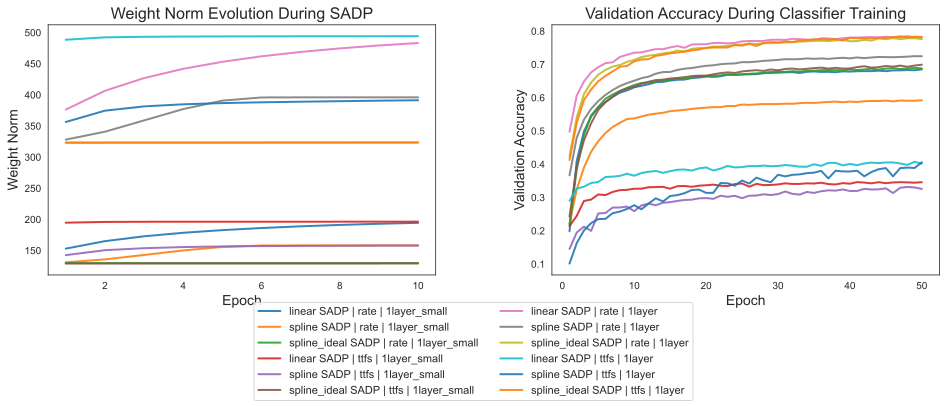

In [5]:
# SUMMARY TABLE (pandas)
df = pd.DataFrame([{
    'Model': r['Model'],
    'Coding': r['Coding'],
    'Classifier': r['Classifier'],
    'Accuracy': r['Accuracy'],
    'F1': r['F1'],
    'Runtime_sec': r['Runtime_sec']
} for r in all_results])

print("\nFinal Benchmark Results:")
print(df.to_markdown(index=False, floatfmt=".4f"))

# save CSV
df.to_csv("sadp_benchmark_results_"+dataset_name+".csv", index=False)

# --- VISUALIZATION: side-by-side plots: weight-norms and val accuracy ---
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

# colors from seaborn palette (do not hardcode colors)
palette = sns.color_palette("tab10", n_colors=len(all_results))

for i, r in enumerate(all_results):
    label = f"{r['Model']} | {r['Coding']} | {r['Classifier']}"
    # plot weight norms (if available)
    wn = np.asarray(r.get('W_norms', []))
    if wn.size > 0:
        axes[0].plot(range(1, len(wn) + 1), wn, label=label, linewidth=2, alpha=0.9)
axes[0].set_title("Weight Norm Evolution During SADP", fontsize=16)
axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].set_ylabel("Weight Norm", fontsize=14)
axes[0].grid(False)

for i, r in enumerate(all_results):
    label = f"{r['Model']} | {r['Coding']} | {r['Classifier']}"
    hist = r.get('History', {})
    val_acc = hist.get('val_accuracy') or hist.get('val_acc') or hist.get('accuracy')  # try common keys
    if val_acc:
        axes[1].plot(range(1, len(val_acc) + 1), val_acc, label=label, linewidth=2, alpha=0.9)
axes[1].set_title("Validation Accuracy During Classifier Training", fontsize=16)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].set_ylabel("Validation Accuracy", fontsize=14)
axes[1].grid(False)

# shared legend
fig.legend(
    handles=axes[0].lines + axes[1].lines,
    labels=[f"{r['Model']} | {r['Coding']} | {r['Classifier']}" for r in all_results],
    loc="lower center",
    fontsize=11,
    frameon=True,
    ncol=2
)
plt.subplots_adjust(bottom=0.30, wspace=0.3)
plt.savefig("training_plots_side_by_side_SADP"+dataset_name+".png", dpi=300, bbox_inches='tight')
plt.show()
